Single qubit errors - transpilation
===========================

This is a simulation of single qubit errors in Qiskit to verify transpiling and the depolarising and measurement noise model.  

In the depolarising error channel in Qiskit the parameter p implies a probability p that a qubit changes to a completely mixed state.  When the qubit is measured then with probability p/2 it will no longer be in the ground state.  
This was checked by applying the noise model to sequential X, Y, Z, H, S and SDG gates, measuring the result, and comparing with a calculation. 

The transpilation process maps each gate to an equivalent gate in the gate set for an Ion computer as follows

 - X -> Rx(Pi)
 - Y -> Rx(Pi/2) Ry(-Pi/2) Rx(Pi/2)
 - Z -> Rx(Pi/2) Ry(-Pi) Rx(-Pi/2)
 - H -> Rx(Pi) Ry(-Pi/2)
 - S -> Rx(Pi/2) Ry(-Pi/2) Rx(-Pi/2)
 - SDG -> Rx(-Pi/2) Ry(-Pi/2) Rx(Pi/2)

Note - a global phase change has been ignored.

if there are a number of sequential gates then the transpilation won’t produce all the expected gates, and so the calculation won't agree.  

This is part of an MSc project on the Steane code.  Please see https://goldsmdn.github.io/ for full details.

Import the necessary function modules.

In [1]:
from qiskit import(
  QuantumCircuit,
  QuantumRegister,
  ClassicalRegister,
  execute,
  Aer)

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.compiler import transpile

import math

from helper_functions import (
    get_noise,
    calculate_standard_error,
    mean_of_list
    ) 

Define constants so the process flow can be controlled from one place:

In [2]:
# gate set for Ion computer noise model
SINGLE_GATE_SET = ['id', 'ry', 'rx']
TWO_GATE_SET = ['rxx']
BASIS_GATE_SET = SINGLE_GATE_SET + TWO_GATE_SET

SHOTS = 10000                                   #Number of shots to run 
MEASURE_NOISE = 0.0                             #Measurement noise
SINGLE_GATE_DEPOLARISING = 0.01                 #Single gate depolarising. 
TWO_GATE_DEPOLARISING = 0.0                     #Two gates not relevant
NOISE = True                                    #Test with noise
GATE_DEPTH = 1                                  #Gate depth
ITERATIONS = 25  
LIST_GATE_TYPES = ['x','y','sdg','s','z']   #List of gates considered in simulation  

PI = math.pi

SIMULATOR = Aer.get_backend('qasm_simulator')

The expected number of measurements in the ground state is estimated, recalling that with probabilily SINGLE_GATE_DEPOLARISING / 2 the gate will no longer be in the ground state. 

In [3]:
#expected = (1 - SINGLE_GATE_DEPOLARISING /2 ) ** (GATE_DEPTH * gate_number) * (1 - MEASURE_NOISE)

For each gate type we find the error.

In [4]:
print(f'Running with {ITERATIONS} iterations')
          
for qubit_type in LIST_GATE_TYPES:
    if qubit_type == 'x':
        gates = 1
    elif qubit_type in ['y', 'z', 's', 'sdg']:
        gates = 3
    elif qubit_type == 'h':
        gates = 2
    else:
        raise Exception('Unexpected qubit type in list')             
    expected = (1 - SINGLE_GATE_DEPOLARISING /2 ) ** (GATE_DEPTH * gates) * (1 - MEASURE_NOISE)
    ground_state_list = []
    for iterations in range(ITERATIONS):
        qr = QuantumRegister(1,'code_qubit')     # One qubit
        cr = ClassicalRegister(1,'syndrome_bit') # One Syndrome bit
        qc = QuantumCircuit(qr,cr)
    
        for i in range(GATE_DEPTH):
        # set up the circuit
            if qubit_type == 'x':
                qc.x(qr[0])
            elif qubit_type == 'y':
                qc.y(qr[0])
            elif qubit_type == 'z':  
                qc.z(qr[0])
            elif qubit_type == 'h': 
                qc.h(qr[0])
            elif qubit_type == 's':  
                qc.s(qr[0])
            elif qubit_type == 'sdg': 
                qc.sdg(qr[0])
            elif qubit_type == 'rx': 
                qc.rx(PI, qr[0])
            else:
                raise Exception('Unexpected qubit type in list')
        qc.measure(qr, cr)
        qt = transpile(qc, basis_gates = BASIS_GATE_SET)
        noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, TWO_GATE_DEPOLARISING, 
                                    SINGLE_GATE_SET, TWO_GATE_SET)
        if NOISE:
            result = execute(qt, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
        else:
            result = execute(qt, SIMULATOR, shots = SHOTS).result() 

        counts = result.get_counts(qt)
        if qubit_type in ['x', 'y', 'rx']:
            ground_state = counts['1'] / SHOTS
        elif qubit_type in ['z','s', 'sdg']:
            ground_state = counts['0'] / SHOTS
        ground_state_list.append(ground_state)
    standard_deviation, standard_error = calculate_standard_error(ground_state_list)
    mean = mean_of_list(ground_state_list)
    print (f'processing qubit type {qubit_type}')
    if qubit_type in ['x', 'y', 'rx']:
        print(f'We expect to see a probability of {expected:.4f} measurements of the |1> state if one gate is used in transpiliation .')
        print(f'With the {qubit_type} gate we saw the |1> state {mean:.4f} of the time')
        print(f'The standard error was {standard_error:.4f}')
    elif qubit_type in ['z','s', 'sdg']:
        print(f'We expect to see a probability of {expected:.4f} measurements of the |0> state if one gate is used in transpiliation.')
        print(f'With the {qubit_type} gate we saw the |0> state {mean:.4f} of the time')
        print(f'The standard error was {standard_error:.4f}')      
    else:
        raise Exception('Unexpected qubit type in list')
    print()

Running with 25 iterations
processing qubit type x
We expect to see a probability of 0.9950 measurements of the |1> state if one gate is used in transpiliation .
With the x gate we saw the |1> state 0.9952 of the time
The standard error was 0.0001

processing qubit type y
We expect to see a probability of 0.9851 measurements of the |1> state if one gate is used in transpiliation .
With the y gate we saw the |1> state 0.9855 of the time
The standard error was 0.0002

processing qubit type sdg
We expect to see a probability of 0.9851 measurements of the |0> state if one gate is used in transpiliation.
With the sdg gate we saw the |0> state 0.9854 of the time
The standard error was 0.0002

processing qubit type s
We expect to see a probability of 0.9851 measurements of the |0> state if one gate is used in transpiliation.
With the s gate we saw the |0> state 0.9850 of the time
The standard error was 0.0002

processing qubit type z
We expect to see a probability of 0.9851 measurements of th

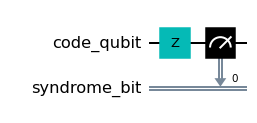

In [5]:
qc.draw(output='mpl', filename = 'Basic_single_qubit_error_circuit.jpg', fold=60)

 An example transpiled circuit is shown below.

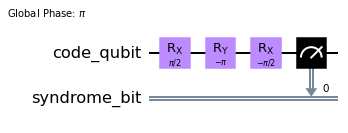

In [6]:
qt.draw(output='mpl', filename = 'Basic_single_qubit_error_transpiled_circuit.jpg', fold=60)